# MP1 MountainCar Miniproject Notebook

## 1 Tutorial

This section is here to guide you through the basics of the frameworks necessary for you to do well on your CS456-Miniproject 🤓

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import secrets

### Gymnasium environments

One of the main and most spread environment developer in the field of RL research is [Gymnasium](https://gymnasium.farama.org/). They provide standardized environments offering a large range of difficulties and setups, that are perfectly designed to benchmark performances of RL and Deep RL algorithms.

The main structure is very simple to understand. First, we need to instantiate our environment. We will use an existing environment, but one could also use their structure to design their own environment.

Let's directly work with the Mountain Car environment that will be used in the project. 

_PS: If you're more curious, feel free to browse the large list available on their website!_

In [2]:
env = gym.make('MountainCar-v0')

The environment contains an action space and an observation (state) space. Let's see what these look like.

In [3]:
print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")

Action space: Discrete(3)
Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)


In [4]:
print(f"Number of actions available: {env.action_space.n}")
print(f"Observation shape: {env.observation_space.shape}")

Number of actions available: 3
Observation shape: (2,)


As we can see, the action space of that first environment is discrete and contains 3 possible actions: accelerate to the left, don't accelerate and accelerate to the right. 

The observation space has a dimension of 2, and you can find what each part represents [here](https://gymnasium.farama.org/environments/classic_control/mountain_car/#observation-space).

Before taking actions, the environment should be reset (or boostrapped). **Note: this should be done every time the environment has to be restarted, i.e., at the end of any episode.**

In [5]:
# the second return value is an info dictionary, but it doesn't contain anything in this environment
starting_state, _ = env.reset() 

print(f"Starting state: {starting_state}")

Starting state: [-0.49923703  0.        ]


Now that we know what the actions look like and that the environment is ready, we can take actions inside it. This is done using the `env.step` function, that takes an action as input, and returns multiple values. More details on each of them can be found [here](https://gymnasium.farama.org/api/env/#gymnasium.Env.step).

In the project, you will have an agent that will choose an action (based on the policy learned) given the current state. However, for now, we can simply sample actions at random using `action_space.sample()`.

In [6]:
action = env.action_space.sample()
print(f"Sampled action: {action}")
next_state, reward, terminated, truncated, _ = env.step(action) # again, the last return value is an empty info object

print(f"Next state: {next_state}")
print(f"Reward: {reward}")
print(f"Terminated: {terminated}")
print(f"Truncated: {truncated}")

Sampled action: 1
Next state: [-4.9941957e-01 -1.8255047e-04]
Reward: -1.0
Terminated: False
Truncated: False


The `terminated` and `truncated`  variables represent the two ways that the episode might be done. Thus, it might be handy to use
```
done = terminated or truncated
```
in your code. 💡

We now have all the pieces necessary to run a full episode!

In [7]:
done = False
state, _ = env.reset()
episode_reward = 0

while not done:
    action = env.action_space.sample()
    next_state, reward, terimnated, truncated, _ = env.step(action)

    episode_reward += reward

    state = next_state
    done = terminated or truncated

print(f"Episode reward after taking random actions: {episode_reward}")

Episode reward after taking random actions: -200.0


Now your goal in the project will be to code an agent that can beat that 🙃

## 2 Random Agent Class

This code block describes the implementation of a random agent as described in task 2 of the project handout.

In [8]:
class RandomAgent:
    def __init__(self, environment):
        self.env = environment

    def observe(self, state, action, next_state, reward):
        # This method is just a placeholder for the random agent, as it doesn't learn from observations.
        return

    def select_action(self, state):
        # Randomly select an action from the action space
        # The state therefore does not need to be taken into account
        return self.env.action_space.sample()

    def update(self):
        # No update necessary for a random agent.
        return

Run the agent on the environment until the episode is either truncated or terminated. Store the episode and render (visualize) it.

In [9]:
def run_single_episode(agent):
    """Run the RandomAgent for a single episode
    """
    done = False
    state, _ = agent.env.reset()
    episode_reward = 0
    states = [state]

    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = agent.env.step(action)
        episode_reward += reward
        
        # observe and update does not do anything for the random agent
        agent.observe(state, action, next_state, reward)
        agent.update()
        
        state = next_state
        states.append(state)

        done = terminated or truncated

    return episode_reward, states

In [10]:
def plot_states_over_time(states):
    """Plot a run of a single episode for the RandomAgent.
    """
    # Extract positions and velocities from states
    positions = [s[0] for s in states]
    velocities = [s[1] for s in states]
    timesteps = list(range(len(states)))

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(timesteps, positions, label='Position')
    plt.title('Car Position Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Position')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(timesteps, velocities, label='Velocity')
    plt.title('Car Velocity Over Time')
    plt.xlabel('Time Step')
    plt.ylabel('Velocity')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

Episode reward after taking random actions: -200.0


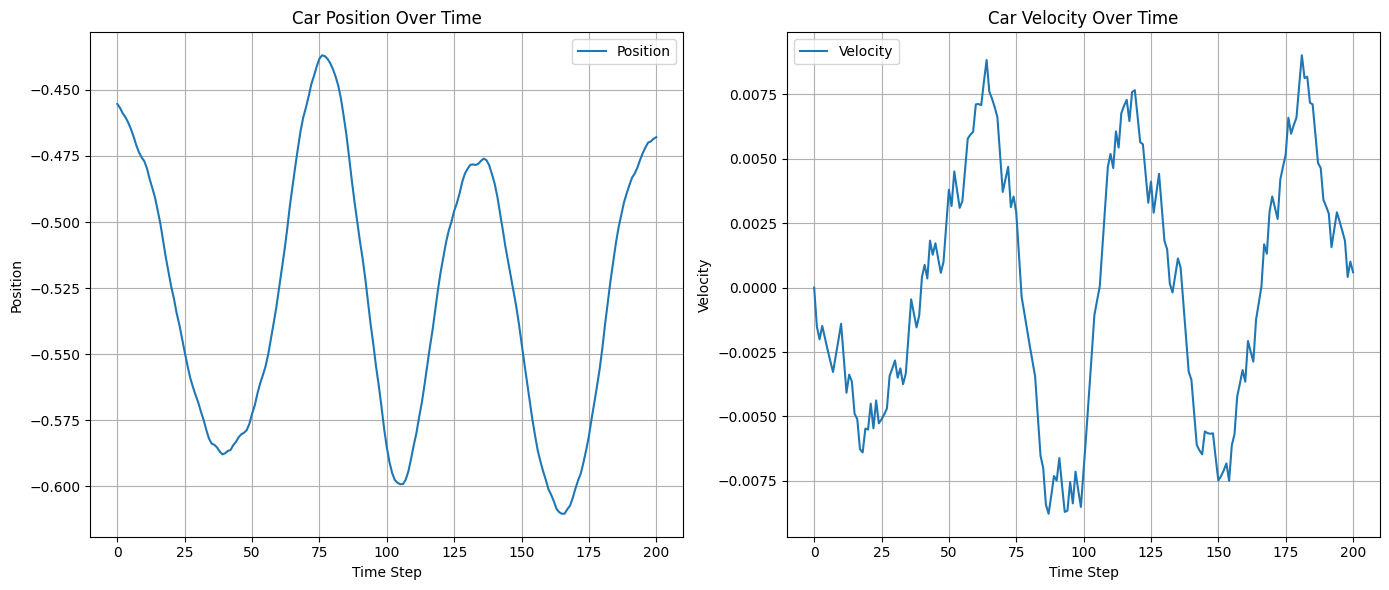

In [11]:
env = gym.make("MountainCar-v0")
random_agent = RandomAgent(env)
episode_reward, states = run_single_episode(random_agent)
print(f"Episode reward after taking random actions: {episode_reward}")
plot_states_over_time(states)

Run the agent for 100 episodes. At every episode initialize the environment with a new randomly sampled seed. Plot the duration of each episode as a scatter plot.

In [11]:
def run_multiple_episodes(agent, num_episodes=100):
    episode_durations = []

    for _ in range(num_episodes):
        done = False
        # Pass integer to forcibly reset PRNG of environment according to gymnasium docs
        # secrets.randbits() generates a random integer with 64 bits
        random_integer = secrets.randbits(64)  
        state = agent.env.reset(seed=random_integer)
        episode_length = 0

        while not done:
            action = agent.select_action(state)
            state, _, terminated, truncated, _ = agent.env.step(action)
            episode_length += 1
            done = terminated or truncated
        
        episode_durations.append(episode_length)
    
    return episode_durations

In [12]:
def plot_episode_durations(episode_durations):
    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(episode_durations)), episode_durations, alpha=0.6)
    plt.title("Duration of Each Episode")
    plt.xlabel("Episode Number")
    plt.ylabel("Duration (in steps)")
    plt.grid(True)
    plt.show()

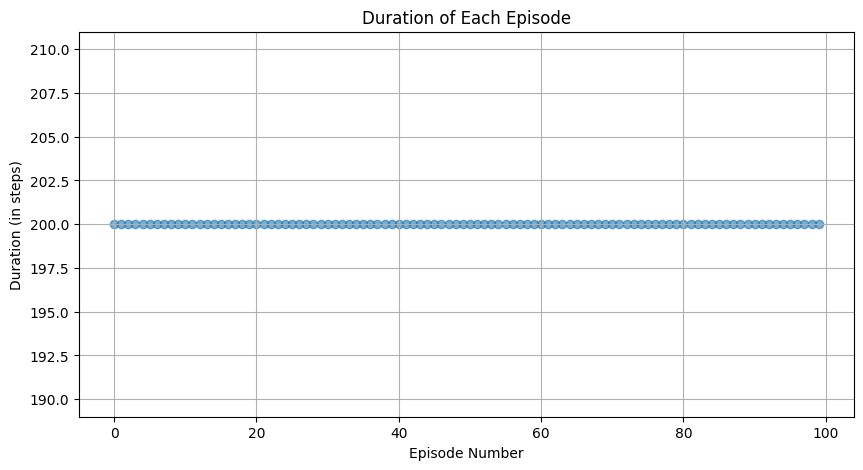

In [14]:
env = gym.make("MountainCar-v0")
random_agent = RandomAgent(env)
durations = run_multiple_episodes(random_agent, 100)
plot_episode_durations(durations)

Note from [Gymnasium Docs](https://www.gymlibrary.dev/environments/classic_control/mountain_car/#episode-end):

> The episode ends if either of the following happens:
>
> 1. **Termination:** The position of the car is greater than or equal to 0.5 (the goal position on top of the right hill)
> 2. **Truncation:** The length of the episode is 200.

So it appears the episode was always truncated before the goal could be reached (i.e. random policy is bad).

## 3  DQN Agent Class

This code block describes the implementation of a DQN agent as described in task 3 of the project handout.

### 3.1 Implementation

In [13]:
# Imports for DQN agent, neural network, and replay buffer
import torch
import torch.nn as nn
import random
import numpy as np
from collections import deque

In [14]:
# Define the Q-network as a MLP
class QNetwork(nn.Module):
    """
    a multi-layer perception (MLP) that takes a state s as input and outputs Q(s,a) for each
    action a

    Attributes
    ----------
    state_size:
        Number of input features, which corresponds to the dimension of the state space.
    action_size:
        Number of output features, which corresponds to the number of possible actions.
    hidden_layers:
        A list specifying the number of neurons in each hidden layer.
        Deafault is two hidden layers with 64 neurons each.
    """
    def __init__(self, state_size, action_size, hidden_layers=[64, 64]):
        super(QNetwork, self).__init__()
        layers = []
        input_size = state_size
        
        # Fully conected layers with ReLU activation
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.ReLU())
            input_size = hidden_size
            
        layers.append(nn.Linear(input_size, action_size))
        self.model = nn.Sequential(*layers) # Unpack list of layers into a sequential model
    
    def forward(self, x):
        return self.model(x)

In [15]:
# Define the replay buffer
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer = deque(maxlen=buffer_size)
    
    def add(self, state, action, next_state, reward, done):
        self.buffer.append((state, action, next_state, reward, done))
        
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

In [16]:
class DQNAgent:
    """
    DQN agent that uses a feed-forward network to estimate Q-values
    and an epsilon-greedy policy to take actions

    Attributes
    ----------
    Q:
        Approximates the Q-values for each state-action pair using a feed-forward neural network.
    replay_buffer:
        Stores experiences as tuples and allows for random sampling to train the Q-network.
        
    Methods
    -------
    update_target_network():
        Updates the target network to match the Q-network to stabilize training.
    """
    def __init__(self, state_size, action_size, hidden_layers=[64, 64],
                 gamma=0.99, epsilon=0.9, epsilon_min=0.05, epsilon_decay=0.995,
                 replay_buffer_size=10000, batch_size=64, lr=0.001):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.current_loss = None
        
        self.Q = QNetwork(state_size, action_size, hidden_layers)
        self.target_Q = QNetwork(state_size, action_size, hidden_layers)
        self.optimizer = torch.optim.AdamW(self.Q.parameters(), lr=lr)
        self.replay_buffer = ReplayBuffer(replay_buffer_size)
        self.update_target_network()
        
    def update_target_network(self):
        self.target_Q.load_state_dict(self.Q.state_dict())

    def observe(self, state, action, next_state, reward, done):
        self.replay_buffer.add(state, action, next_state, reward, done)

    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                action_values = self.Q(state_tensor)
            return torch.argmax(action_values).item()

    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        
        batch = self.replay_buffer.sample(self.batch_size)
        states, actions, next_states, rewards, dones = zip(*batch)
        
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)
        
        # Debugging
        # print(f"states shape: {states.shape}")
        # print(f"next_states shape 2: {next_states.shape}")
        # print(f"actions shape: {actions.shape}")
        
        current_q_values = self.Q(states).gather(1, actions)
        next_q_values = self.target_Q(next_states).max(1)[0].unsqueeze(1)
        target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))
        
        loss = nn.MSELoss()(current_q_values, target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        self.current_loss = loss

In [55]:
# Test the DQN agent
env = gym.make("MountainCar-v0")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

dqn_agent = DQNAgent(state_size, action_size)

num_episodes = 10
for episode in range(num_episodes):
    state, _ = env.reset()
    done = False
    
    while not done:
        action = dqn_agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        dqn_agent.observe(state, action, next_state, reward, done)
        dqn_agent.update()
        
        state = next_state
        
    dqn_agent.update_target_network()
    print(f"Episode {episode + 1}/{num_episodes} finished")

Episode 1/10 finished
Episode 2/10 finished
Episode 3/10 finished
Episode 4/10 finished
Episode 5/10 finished
Episode 6/10 finished
Episode 7/10 finished
Episode 8/10 finished
Episode 9/10 finished
Episode 10/10 finished


### 3.2 No auxiliary reward

Train the DQNAgent for 1000 episodes and report its loss and average cumulative reward per episode.

In [17]:
def train_dqn(agent, env, num_episodes=1000):
    episode_rewards = []
    losses = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        cumulative_reward = 0
        episode_loss = []

        while not done:
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.observe(state, action, next_state, reward, done)
            agent.update()

            cumulative_reward += reward
            state = next_state
            
            # Collect loss for this episode
            if hasattr(agent, "current_loss") and agent.current_loss is not None:
                episode_loss.append(agent.current_loss)

        agent.update_target_network()
        episode_rewards.append(episode_reward)
        
        # Append average loss for this episode
        if episode_loss:
            # losses.append(np.mean(episode_loss))
            losses.append(np.mean([loss.detach().numpy() for loss in episode_loss]))
        else:
            losses.append(0)
            
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            print(f"Episode {episode + 1}/{num_episodes}. Average reward: {avg_reward:.2f}")
            
    return episode_rewards, losses

In [ ]:
# Train the agent
env = gym.make("MountainCar-v0")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

dqn_agent = DQNAgent(state_size, action_size)
episode_rewards, losses = train_dqn(dqn_agent, env, num_episodes=1000)

# Plotting results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(losses)
plt.title('Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.grid()

plt.tight_layout()
plt.show()

# Calculate and print average cumulative reward over the last 100 episodes
average_cumulative_reward = np.mean(episode_rewards[-100:])
print(f"Average cumulative reward over the last 100 episodes: {average_cumulative_reward:.2f}")

Does your agent solve the task?

**No, it does not.**

The main challenge of this task is the sparse reward problem discussed in the introduction. Let’s
explore ways to address this issue and help our agent to learn faster.

### 3.3 Heuristic reward function

We will now create an auxiliary reward function to assist the agent in learning better behavior. Try
to think of a reward that would help the agent solve the task. Which states location-wise should the
agent strive for?

**A possible heuristic reward is to provide positive feedback based on the agent's progress towards the goal. For example, a reward proportional to the car's position (the further right, the higher the reward).**

Note: Keep in mind that the car needs to move backwards and forwards to gain momentum.

In [19]:
def calculate_auxiliary_reward(state):
    """
    Simple auxiliary reward proportional to the car's position.
    
    Note that the position takes values between -1.2 and +0.6 in the MountainCar environment.
    Thus, it is highest when the car is closest to the flag.
    """
    position = state[0]
    return position

In [20]:
def train_dqn_with_auxiliary_reward(agent, env, num_episodes=3000):
    episode_durations = []
    episode_rewards = []
    episode_auxiliary_rewards = []
    episode_total_rewards = []
    successes = 0
    cumulative_successes = []
    losses = []
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        cumulative_reward = 0
        cumulative_auxiliary_reward = 0
        episode_loss = []
        steps = 0
        
        while not done:
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Calculate auxiliary reward
            auxiliary_reward = calculate_auxiliary_reward(next_state)
            total_reward = reward + auxiliary_reward
            
            agent.observe(state, action, next_state, total_reward, done)
            agent.update()
            
            cumulative_reward += reward
            cumulative_auxiliary_reward += auxiliary_reward
            steps += 1
            state = next_state
            
            # Collect loss for this episode
            if hasattr(agent, "current_loss") and agent.current_loss is not None:
                episode_loss.append(agent.current_loss)
                
        agent.update_target_network()
        episode_durations.append(steps)
        episode_rewards.append(cumulative_reward)
        episode_auxiliary_rewards.append(cumulative_auxiliary_reward)
        episode_total_rewards.append(cumulative_reward + cumulative_auxiliary_reward)
        
        if terminated and not truncated:
            successes += 1
        
        cumulative_successes.append(successes)
        
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_total_rewards[-100:])
            print(f"Episode {episode + 1}/{num_episodes}. Average reward: {avg_reward:.2f}")
            
        # Append average loss for this episode
        if episode_loss:
            losses.append(np.mean([loss.detach().numpy() for loss in episode_loss]))
        else:
            losses.append(0)
            
    return episode_durations, episode_rewards, episode_auxiliary_rewards, episode_total_rewards, cumulative_successes, losses

In [85]:
# Train the agent with auxiliary reward
dqn_agent = DQNAgent(state_size, action_size)
episode_durations, episode_rewards, episode_auxiliary_rewards, episode_total_rewards, \
    cumulative_successes, losses = train_dqn_with_auxiliary_reward(dqn_agent, env, num_episodes=3000)
# Takes 10-15 minutes to run

Episode 100/3000. Average reward: -276.71
Episode 200/3000. Average reward: -242.36
Episode 300/3000. Average reward: -188.50
Episode 400/3000. Average reward: -206.66
Episode 500/3000. Average reward: -220.23
Episode 600/3000. Average reward: -225.00
Episode 700/3000. Average reward: -206.79
Episode 800/3000. Average reward: -199.98
Episode 900/3000. Average reward: -185.55
Episode 1000/3000. Average reward: -183.36
Episode 1100/3000. Average reward: -160.57
Episode 1200/3000. Average reward: -184.99
Episode 1300/3000. Average reward: -199.98
Episode 1400/3000. Average reward: -203.15
Episode 1500/3000. Average reward: -197.94
Episode 1600/3000. Average reward: -204.92
Episode 1700/3000. Average reward: -201.61
Episode 1800/3000. Average reward: -206.50
Episode 1900/3000. Average reward: -183.80
Episode 2000/3000. Average reward: -195.83
Episode 2100/3000. Average reward: -176.88
Episode 2200/3000. Average reward: -184.73
Episode 2300/3000. Average reward: -212.01
Episode 2400/3000. A

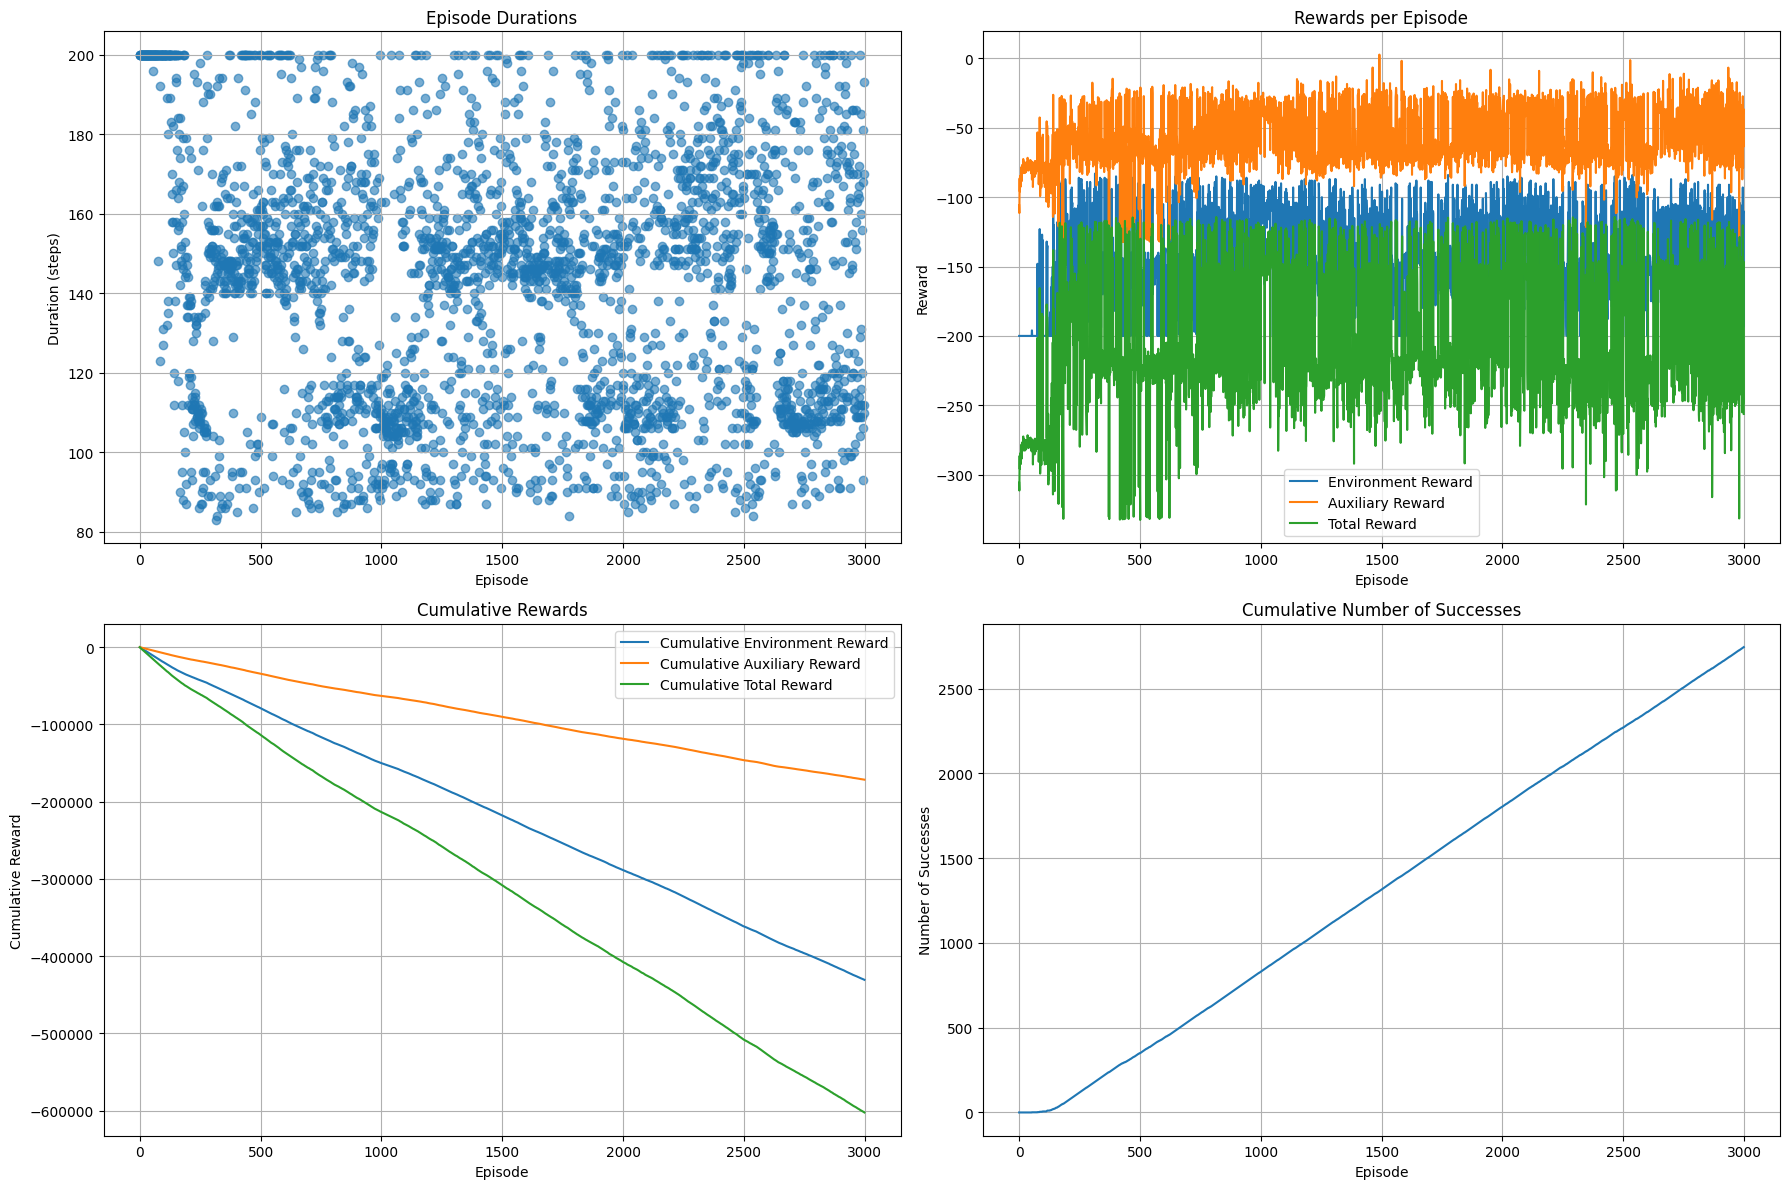

Average cumulative reward over the last 100 episodes: -193.37


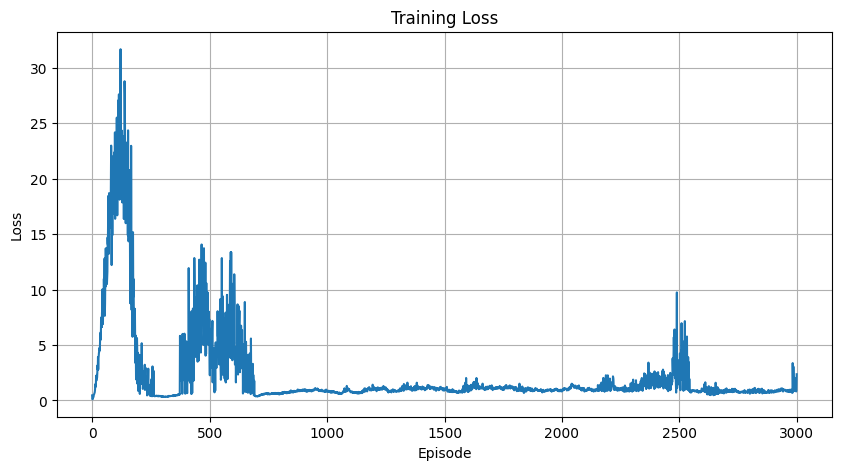

In [86]:
# Plotting results
plt.figure(figsize=(18, 12))

# Episode durations
plt.subplot(2, 2, 1)
plt.scatter(range(len(episode_durations)), episode_durations, alpha=0.6)
plt.title('Episode Durations')
plt.xlabel('Episode')
plt.ylabel('Duration (steps)')
plt.grid()

# Rewards
plt.subplot(2, 2, 2)
plt.plot(episode_rewards, label='Environment Reward')
plt.plot(episode_auxiliary_rewards, label='Auxiliary Reward')
plt.plot(episode_total_rewards, label='Total Reward')
plt.title('Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.grid()

# Cumulative rewards
plt.subplot(2, 2, 3)
cumulative_env_rewards = np.cumsum(episode_rewards)
cumulative_aux_rewards = np.cumsum(episode_auxiliary_rewards)
cumulative_total_rewards = np.cumsum(episode_total_rewards)
plt.plot(cumulative_env_rewards, label='Cumulative Environment Reward')
plt.plot(cumulative_aux_rewards, label='Cumulative Auxiliary Reward')
plt.plot(cumulative_total_rewards, label='Cumulative Total Reward')
plt.title('Cumulative Rewards')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.grid()

# Cumulative number of successes
plt.subplot(2, 2, 4)
plt.plot(cumulative_successes)
plt.title('Cumulative Number of Successes')
plt.xlabel('Episode')
plt.ylabel('Number of Successes')
plt.grid()

plt.tight_layout()
plt.show()

# Calculate and print average cumulative reward over the last 100 episodes
average_cumulative_reward = np.mean(episode_total_rewards[-100:])
print(f"Average cumulative reward over the last 100 episodes: {average_cumulative_reward:.2f}")

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.grid()
plt.show()

Does it successfully solve the task?
What happens if you choose very small/very large auxiliary rewards?

Experiment with the parameters of your auxiliary reward to improve the performance. With a good set of parameters, it should solve the task in less than a thousand episodes.

### 3.4 Non domain-specific reward

Implementation of Random Network Distillation (RND) [Burda et al.](https://arxiv.org/pdf/1810.12894).

Consisting of:
- **Target Network** with fixed ranodom weights. Input: State, Output: Single Number.
- **Predictor Network** with adaptable weights. Input: State, Output: Single Number.

In [21]:
class RNDNetwork(nn.Module):
    def __init__(self, input_dim):
        super(RNDNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        return self.net(x)

In [22]:
class DQNAgent_RND(DQNAgent):
    def __init__(self, state_size, action_size, hidden_layers=[64, 64],
                 gamma=0.99, epsilon=0.9, epsilon_min=0.05, epsilon_decay=0.995,
                 replay_buffer_size=10000, batch_size=64, lr=0.001, reward_factor=0.1):
        super().__init__(state_size, action_size, hidden_layers, gamma, epsilon,
                         epsilon_min, epsilon_decay, replay_buffer_size, batch_size, lr)
        self.reward_factor = reward_factor
        self.predictor = RNDNetwork(state_size)
        self.target = RNDNetwork(state_size)
        self.rnd_optimizer = torch.optim.Adam(self.predictor.parameters(), lr=lr)
        
        self.state_mean = np.zeros(state_size)
        self.state_var = np.ones(state_size)
        self.rnd_mean = 0
        self.rnd_var = 1
        self.steps = 0
    
    def update_normalization_stats(self, state):
        self.steps += 1
        alpha = 1.0 / self.steps
        self.state_mean = (1 - alpha) * self.state_mean + alpha * state
        self.state_var = (1 - alpha) * self.state_var + alpha * (state - self.state_mean) ** 2
        
    def normalize_state(self, state):
        return (state - self.state_mean) / (np.sqrt(self.state_var) + 1e-8)
    
    def compute_rnd_reward(self, next_state):
        normalized_state = self.normalize_state(next_state)
        normalized_state = torch.FloatTensor(normalized_state).unsqueeze(0)
        
        with torch.no_grad():
            target_output = self.target(normalized_state)
        predictor_output = self.predictor(normalized_state)
        
        rnd_error = (predictor_output - target_output).pow(2).mean().item()
        alpha = 1.0 / max(1, self.steps - 100) # Start normalizing after 100 steps
        self.rnd_mean = (1 - alpha) * self.rnd_mean + alpha * rnd_error
        self.rnd_var = (1 - alpha) * self.rnd_var + alpha * (rnd_error - self.rnd_mean) ** 2
        
        normalized_rnd_error = (rnd_error - self.rnd_mean) / (np.sqrt(self.rnd_var) + 1e-8)
        rnd_reward = np.clip(normalized_rnd_error, -5, 5)
        
        return rnd_reward
    
    def update_predictor(self, state):
        self.rnd_optimizer.zero_grad()
        normalized_state = self.normalize_state(state)
        normalized_state = torch.FloatTensor(normalized_state).unsqueeze(0)
        
        target_output = self.target(normalized_state)
        predictor_output = self.predictor(normalized_state)
        
        loss = nn.MSELoss()(predictor_output, target_output) # TODO: need detach()?
        loss.backward()
        self.rnd_optimizer.step()
        
        return loss.item()
    
    def observe(self, state, action, next_state, reward, done):
        self.replay_buffer.add(state, action, next_state, reward, done)
        self.update_normalization_stats(next_state)
        
    def update(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        
        batch = self.replay_buffer.sample(self.batch_size)
        states, actions, next_states, rewards, dones = zip(*batch)
        
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards).unsqueeze(1)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones).unsqueeze(1)
        
        # Compute Q-Values
        current_q_values = self.Q(states).gather(1, actions)
        next_q_values = self.target_Q(next_states).max(1)[0].unsqueeze(1)
        target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))
        
        loss = nn.MSELoss()(current_q_values, target_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        self.current_loss = loss.item()
        
        # Update predictor network
        for next_state in next_states:
            self.update_predictor(next_state.numpy())
            
    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                action_values = self.Q(state_tensor)
            return torch.argmax(action_values).item()
                

In [23]:
def train_dqn_rnd(agent, env, num_episodes=100):
    episode_durations = []
    episode_rewards = []
    episode_rnd_rewards = []
    episode_total_rewards = []
    cumulative_successes = []
    successes = 0
    losses = []
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        cumulative_reward = 0
        cumulative_rnd_reward = 0
        steps = 0
        episode_loss = []
        
        while not done:
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            rnd_reward = agent.compute_rnd_reward(next_state)
            total_reward = reward + agent.reward_factor * rnd_reward
            
            agent.observe(state, action, next_state, total_reward, done)
            agent.update()
            
            cumulative_reward += reward
            cumulative_rnd_reward += rnd_reward
            state = next_state
            steps += 1
            
            # Collect loss for this episode
            if hasattr(agent, "current_loss") and agent.current_loss is not None:
                episode_loss.append(agent.current_loss)
                
        agent.update_target_network()
        episode_durations.append(steps)
        episode_rewards.append(cumulative_reward)
        episode_rnd_rewards.append(cumulative_rnd_reward)
        episode_total_rewards.append(cumulative_reward + agent.reward_factor * cumulative_rnd_reward)
        
        if terminated and not truncated:
            successes += 1
            
        cumulative_successes.append(successes)
        
        # Append average loss for this episode
        if episode_loss:
            losses.append(np.mean([loss for loss in episode_loss])) # TODO: need loss.detach().numpy() for loss in?
        else:
            losses.append(0)
            
        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(episode_total_rewards[-10:])
            print(f"Episode {episode + 1}/{num_episodes}. Average reward: {avg_reward:.2f}")
            
    return episode_durations, episode_rewards, episode_rnd_rewards, episode_total_rewards, cumulative_successes, losses

Train the agent with RND reward and plot results.

In [24]:
env = gym.make("MountainCar-v0")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

dqn_rnd_agent = DQNAgent_RND(state_size, action_size)
episode_durations, episode_rewards, episode_rnd_rewards, episode_total_rewards, cumulative_successes, losses = \
    train_dqn_rnd(dqn_rnd_agent, env, num_episodes=100)

Episode 10/100. Average reward: -203.84
Episode 20/100. Average reward: -201.06
Episode 30/100. Average reward: -201.68
Episode 40/100. Average reward: -201.01
Episode 50/100. Average reward: -202.44
Episode 60/100. Average reward: -201.79
Episode 70/100. Average reward: -196.16
Episode 80/100. Average reward: -202.13
Episode 90/100. Average reward: -200.96
Episode 100/100. Average reward: -199.21


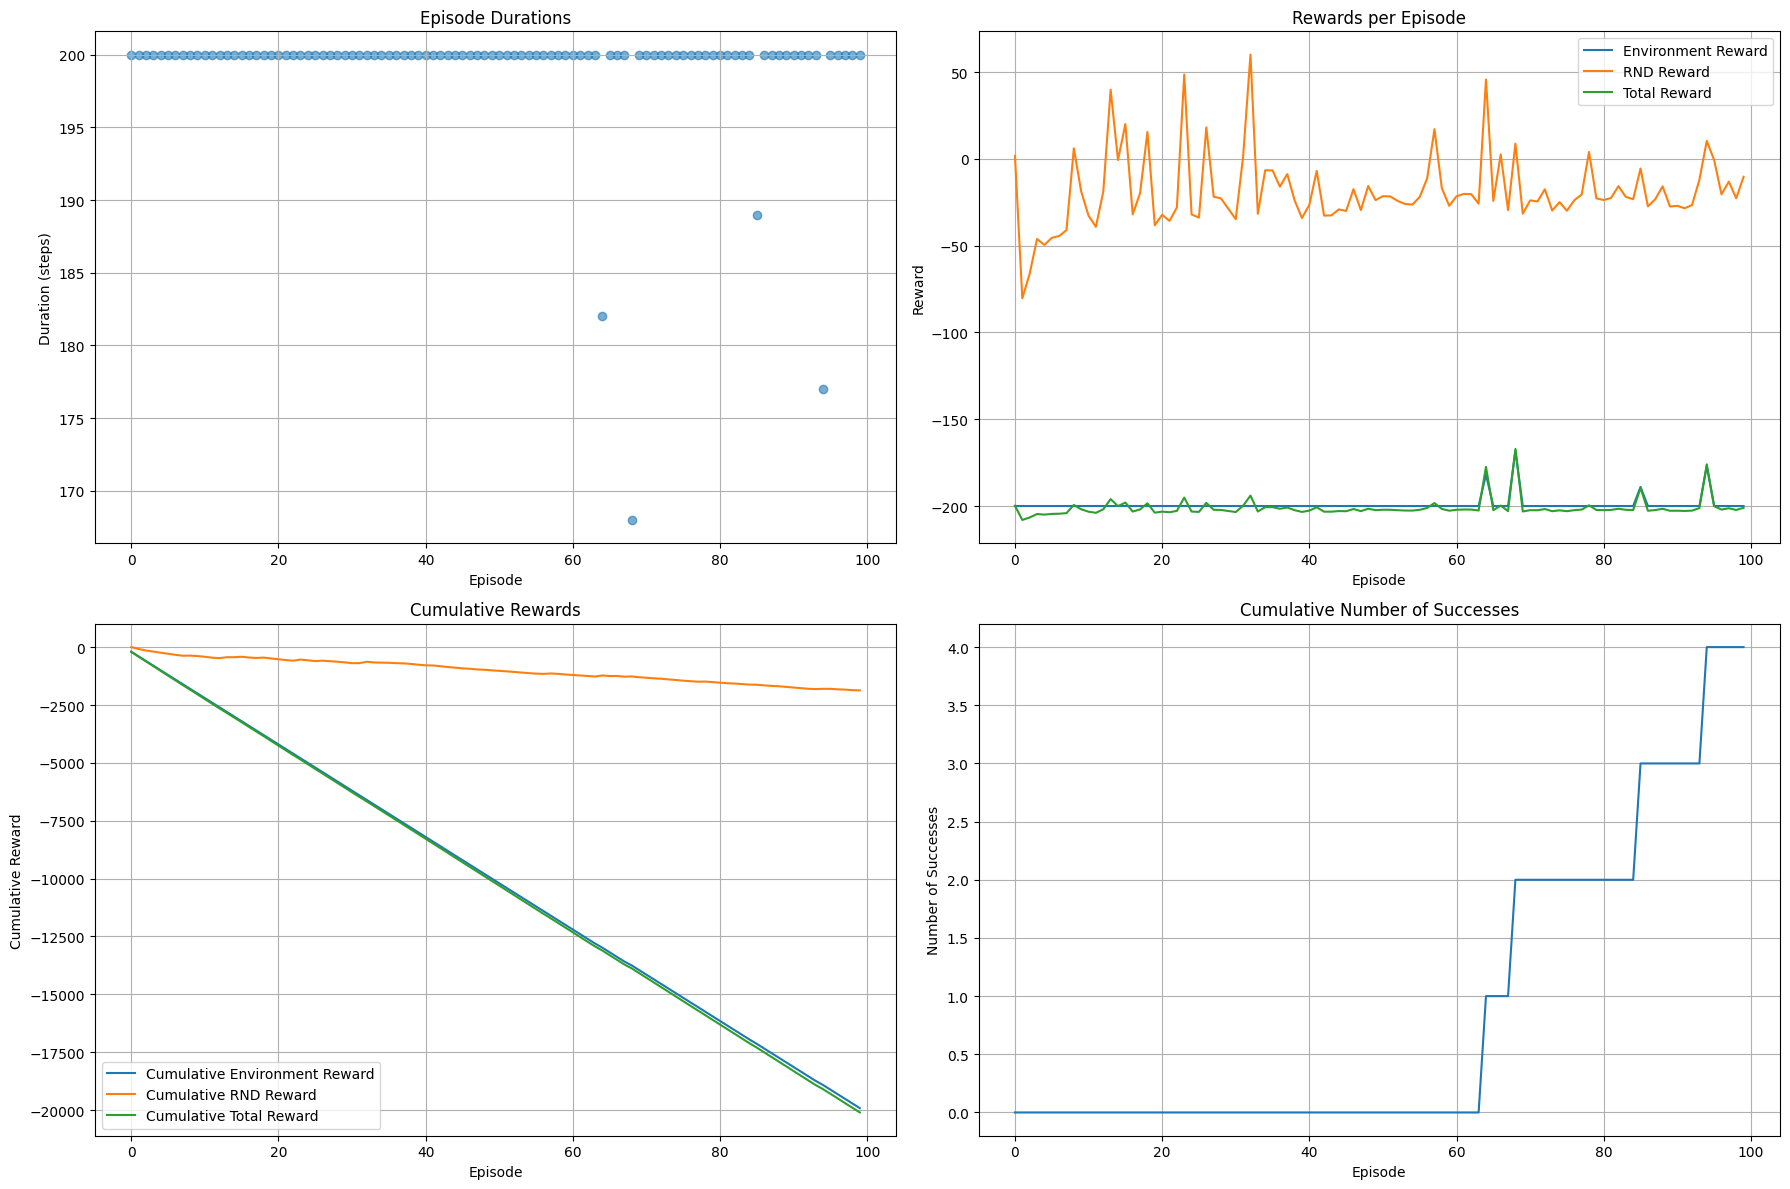

Average cumulative reward over the last 100 episodes: -199.21


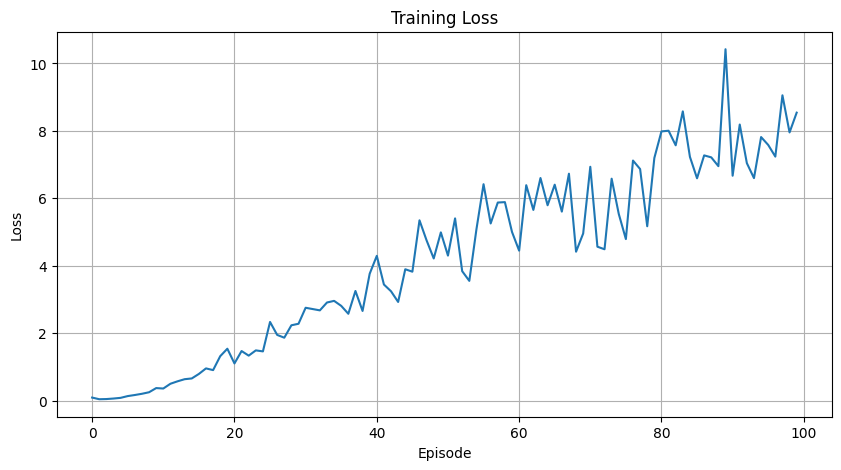

In [25]:
# Plotting results
plt.figure(figsize=(18, 12))

# Episode durations
plt.subplot(2, 2, 1)
plt.scatter(range(len(episode_durations)), episode_durations, alpha=0.6)
plt.title('Episode Durations')
plt.xlabel('Episode')
plt.ylabel('Duration (steps)')
plt.grid()

# Rewards
plt.subplot(2, 2, 2)
plt.plot(episode_rewards, label='Environment Reward')
plt.plot(episode_rnd_rewards, label='RND Reward')
plt.plot(episode_total_rewards, label='Total Reward')
plt.title('Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.grid()

# Cumulative rewards
plt.subplot(2, 2, 3)
cumulative_env_rewards = np.cumsum(episode_rewards)
cumulative_rnd_rewards = np.cumsum(episode_rnd_rewards)
cumulative_total_rewards = np.cumsum(episode_total_rewards)
plt.plot(cumulative_env_rewards, label='Cumulative Environment Reward')
plt.plot(cumulative_rnd_rewards, label='Cumulative RND Reward')
plt.plot(cumulative_total_rewards, label='Cumulative Total Reward')
plt.title('Cumulative Rewards')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.grid()

# Cumulative number of successes
plt.subplot(2, 2, 4)
plt.plot(cumulative_successes)
plt.title('Cumulative Number of Successes')
plt.xlabel('Episode')
plt.ylabel('Number of Successes')
plt.grid()

plt.tight_layout()
plt.show()

# Calculate and print average cumulative reward over the last 10 episodes
average_cumulative_reward = np.mean(episode_total_rewards[-10:])
print(f"Average cumulative reward over the last 10 episodes: {average_cumulative_reward:.2f}")

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.grid()
plt.show()

## Dyna Agent Class

This code block describes the implementation of a Dyna agent as described in task 4 of the project handout.

### 4.1 State Discretization

In [4]:
# We discretize the continuous state ranges into bins by making use of the numpy library
# The following function returns a discretization of the continuous space into bins as desired
def discretize_state_space(position_step, velocity_step):
    position_space = np.arange(start=-1.2, stop=(0.6+position_step), step=position_step)
    velocity_space = np.arange(start=-0.07, stop=(0.07), step=velocity_step)
    return position_space, velocity_space

#### The following helper function can be used to discretize a single state in the state space layout

In [5]:
# We check which position and velocity are closest to the given one in the discretized setting
# We return the index in the state list as an identifier for other tables
def discretize_state(position_space, velocity_space, state):
    posarray = np.abs(position_space - state[0])
    index1 = posarray.argmin()
    veloarray = np.abs(velocity_space - state[1])
    index2 = veloarray.argmin()
    return (position_space[index1], velocity_space[index2])

### 4.2 Model Building & 4.3 Implementation

In [55]:
env = gym.make("MountainCar-v0")


class DynaAgent:
    def __init__(self, discr_step=np.array([0.025, 0.005]), gamma=0.99, epsilon=0.9, epsilon_min=0.05, 
                 epsilon_decay=0.995, k=0, n_states=73*29, n_actions=3, number_of_episodes=10, environment=env):
        # Initialize attributes that can be passed as simple parameters
        self.discr_step = discr_step
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.k = k
        self.n_states = n_states
        self.n_actions = n_actions
        self.number_of_episodes = number_of_episodes
        self.environment = environment     

        # Initialize complex attributes and adjust dependent attributes based on passed parameters
        self.P_hat = np.zeros(shape=(n_states, n_actions, n_states))
        self.P_hat[:, :, :] = np.full(shape=n_states, fill_value=(1/n_states))
        self.R_hat = np.zeros(shape=(n_states, n_actions))
        self.Q = np.zeros(shape=(n_states, n_actions))

        # Initialize helper attributes for updating the model view of the agent
        self.visit_counts = np.zeros(shape=(n_states, n_actions, n_states))
        self.cumulative_returns = np.zeros(shape=(n_states, n_actions))

        # Perform discretization of the state space and store it with the agent object
        self.discrete_positions, self.discrete_velocities = discretize_state_space(discr_step[0], discr_step[1])

        # Store all possible states (= all possible combinations of position and velocity) in table
        self.discrete_states = [(pos,velo) for pos in list(self.discrete_positions) for velo in list(self.discrete_velocities)]

        # Store a list keeping track of previously encountered state-action pairs
        self.state_action_buffer = []
        
    def observe(self, state, action, next_state, reward):

        # Perform the 4 states outlined in the handout

        # Step 1: Discretize the obtained states s and s'
        # Note that the states are returned as a tuple by the function
        state_s = discretize_state(self.discrete_positions, self.discrete_velocities, state)
        state_s_index = self.discrete_states.index(state_s)
        state_sPrime = discretize_state(self.discrete_positions, self.discrete_velocities, next_state)
        state_sPrime_index = self.discrete_states.index(state_sPrime)

        # Record visited state-action pairs in our buffer structure
        # Note that we store the index of the visited state as it enables more lightweight coding
        self.state_action_buffer.append((state_s_index, action))

        # Step 2: Update the model of the transition probabilities and the expected reward
        self.visit_counts[state_s_index][action][state_sPrime_index] += 1
        self.cumulative_returns[state_s_index][action] += reward

        self.P_hat[state_s_index][action][state_sPrime_index] = self.visit_counts[state_s_index][action][state_sPrime_index] / np.sum(self.visit_counts[state_s_index][action])
        self.R_hat[state_s_index][action] = self.cumulative_returns[state_s_index][action] / np.sum(self.visit_counts[state_s_index][action])

        # Step 3: Update the Q-value at state s according to the formula on the handout

        # Prepare the sum factor to be multiplied with gamma first
        sumVal = 0
        for pointer, _ in enumerate(self.discrete_states):
            sumVal += (self.P_hat[state_s_index][action][pointer] * np.max(self.Q[pointer]))

        # Perform the actual Q-value update
        self.Q[state_s_index][action] = self.R_hat[state_s_index][action] + (self.gamma * sumVal)

        # Step 4: Perform k further Q-value updates for randomly chosen state-action pairs that were already encountered
        for _ in range(self.k):
            idx, act = random.sample(self.state_action_buffer, 1)[0]

            # Now perform the actual update of the Q-value as in Step 3
            sumVal = 0
            for pointer, _ in enumerate(self.discrete_states):
                sumVal += (self.P_hat[idx][act][pointer] * np.max(self.Q[pointer]))

            self.Q[idx][act] = self.R_hat[idx][act] + (self.gamma * sumVal)

        return

    def select_action(self, state):

        # Pick an action from the given state according to epsilon greedy policy on the Q-values

        if np.random.rand() <= self.epsilon:
            return env.action_space.sample()
        else:
            discreteState = discretize_state(self.discrete_positions, self.discrete_velocities, state)
            valsQ = self.Q[self.discrete_states.index(discreteState)]
            return np.argmax(valsQ)

    def update(self):

        # Runs the training procedure

        for episode in range(self.number_of_episodes):
            state, _ = self.environment.reset()
            done = False

            while not done:
                action = self.select_action(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated

                self.observe(state, action, next_state, reward)

                # Remember to adjust the epsilon value to decay in training
                self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

                state = next_state
            
            print(f"Episode {episode + 1}/{self.number_of_episodes} finished")
        
        return

### 4.4 Results

#### We obtain results for the DynaAgent as instructed in the handout

In [56]:
# To be implemented later.

#### The subsequent cell is used for debugging

In [57]:
agent = DynaAgent(k=1, number_of_episodes=20)
agent.update()

[-0.55644387  0.        ]
Episode 1/20 finished
[-0.50771093  0.        ]
Episode 2/20 finished
[-0.49486735  0.        ]
Episode 3/20 finished
[-0.59636253  0.        ]
Episode 4/20 finished
[-0.5628216  0.       ]
Episode 5/20 finished
[-0.5584188  0.       ]
Episode 6/20 finished
[-0.51395017  0.        ]
Episode 7/20 finished
[-0.46534604  0.        ]
Episode 8/20 finished
[-0.4374512  0.       ]
Episode 9/20 finished
[-0.44790983  0.        ]
Episode 10/20 finished
[-0.40770486  0.        ]
Episode 11/20 finished
[-0.47610125  0.        ]
Episode 12/20 finished
[-0.43804228  0.        ]
Episode 13/20 finished
[-0.4926282  0.       ]
Episode 14/20 finished
[-0.43463162  0.        ]
Episode 15/20 finished
[-0.59562176  0.        ]
Episode 16/20 finished
[-0.5866384  0.       ]
Episode 17/20 finished
[-0.45254296  0.        ]
Episode 18/20 finished
[-0.47208947  0.        ]
Episode 19/20 finished
[-0.5827698  0.       ]
Episode 20/20 finished
